In [1]:
from __future__ import annotations

import pickle

import numpy as np
from mpi4py import MPI
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.block_tridiag import greenfunction
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.projector import expand

comm = MPI.COMM_WORLD
rank = comm.Get_rank()


[anooja-ThinkPad-X1-Carbon-Gen-11:11766] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
import matplotlib.pyplot as plt
import numpy as np


# Set global matplotlib rc parameters for better readability
plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})

In [3]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_identity, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def run(outputfile):
    gd = GridDesc(energies, 1, float)
    T = np.empty(gd.energies.size)
    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy)

    T = gd.gather_energies(T)

    if comm.rank == 0:
        np.save(outputfile, (energies, T.real))

In [9]:
data_folder = "./output/lowdin"
dmft_data_folder = "./output/lowdin/U_matrix"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
dmft_sigma_file = f"{dmft_data_folder}/dmft_sigma.npy"


In [26]:
dmft_temp = np.load(dmft_sigma_file)
dmft_temp.shape

(401, 9, 9)

In [10]:
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 5e-3

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)
with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

In [31]:
np.where(np.max(np.abs(dmft_temp.imag)))[0]

array([0])

In [34]:
np.argmax(np.abs(dmft_temp[:,4,4].imag))

153

In [35]:
energies[153]

-0.47

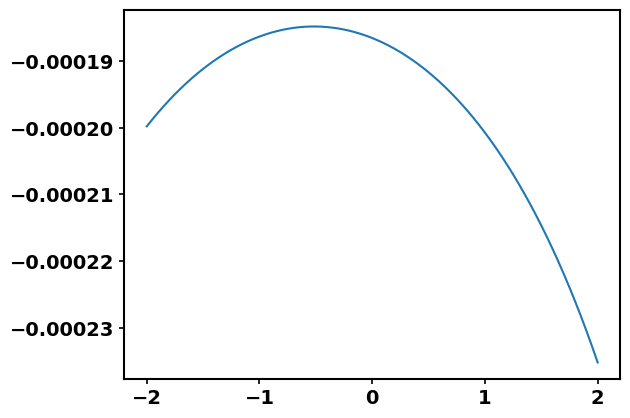

In [37]:

plt.plot(energies,dmft_temp[:,2,2].imag)

In [11]:
nodes = [0, 810, 1116, 1278, 1584, 2394]

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
)

In [12]:
if comm.rank == 0:
    dmft_sigma = load(dmft_sigma_file)
else:
    dmft_sigma = None

# Transmission function calculation
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
S_identity = np.eye(S_molecule.shape[0])
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule

dmft_sigma = comm.bcast(dmft_sigma, root=0)
self_energy[2] = dmft_sigma
gf.selfenergies.append((imb, self_energy[2]))

In [23]:
dmft_sigma.retarded(0.0).shape

(162, 162)

In [13]:
self_energy[2].retarded(0.0).shape

(162, 162)

In [14]:
S_molecule.shape

(162, 162)

In [15]:
self_energy[2].retarded(-0.5)

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


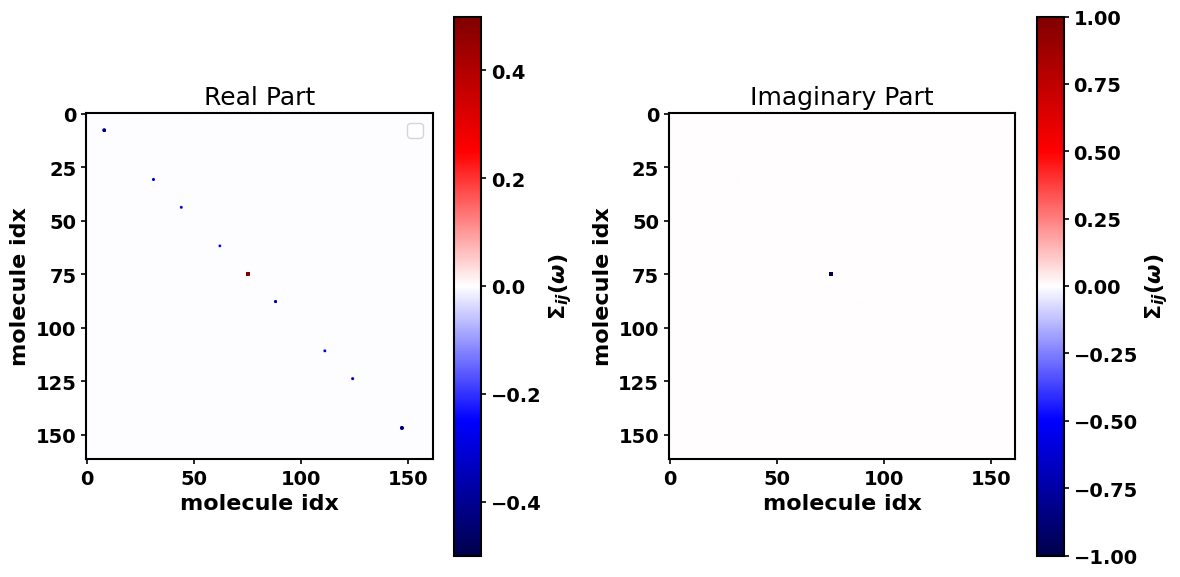

In [36]:

omega = -0.47
matrix_real = self_energy[2].retarded(omega).real
matrix_imag = self_energy[2].retarded(omega).imag

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# im1 = axes[0].imshow(matrix_real, cmap='seismic', vmin=-np.max(np.abs(matrix_real)), vmax=np.max(np.abs(matrix_real)))
im1 = axes[0].imshow(matrix_real, cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0].set_title('Real Part')
axes[0].set_xlabel('molecule idx')
axes[0].set_ylabel('molecule idx')
fig.colorbar(im1, ax=axes[0], label=r'$\Sigma_{ij}(\omega)$')

# for idx in idx_molecule:
#     axes[0].scatter(idx, idx, color='black', marker='.', s=50, label='Impurity' if idx == idx_molecule[0] else "")

# im2 = axes[1].imshow(matrix_imag, cmap='seismic', vmin=-np.max(np.abs(matrix_imag)), vmax=np.max(np.abs(matrix_imag)))
im2 = axes[1].imshow(matrix_imag, cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title('Imaginary Part')
axes[1].set_xlabel('molecule idx')
axes[1].set_ylabel('molecule idx')
fig.colorbar(im2, ax=axes[1], label=r'$\Sigma_{ij}(\omega)$')

# for idx in idx_molecule:
#     axes[1].scatter(idx, idx, color='black', marker='.', s=50, label='Impurity' if idx == idx_molecule[0] else "")

axes[0].legend(loc='upper right')

plt.tight_layout()
plt.show()
